# dmarketing.ai

## Deep Learning

## Project: Build a reviews' classifier based on Amazon's reviews dataset

*__dmarketing.ai__* (*Digital Marketing AI*) is a deep learning project focused on building severally, vastly diverse usage, neural net models. <br /><br /> 
In this _Jupyter Notebook_ you will find step by step build Recurrent Neural Network that can perform review sentiment classification and deside whether customer review was : *'negative', 'neutral' , 'positive'*. <br /> 
Dataset for building a classifier were downloaded from [link](https://registry.opendata.aws/amazon-reviews/#usageexamples) and contains *train.csv* and *test.csv* files which contain training and testing data respectivly.

## Design sequential architecture that takes review as an input and outputs sentiment.

### Step 1: Load & Explore Dataset

In [1]:
import os

DATA_FOLDER_PATH = "./data"
TRAIN_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'train.csv')
TEST_DATA_PATH = os.path.join(DATA_FOLDER_PATH, 'test.csv')

#### Counting the number of samples available in the csv_file.

I constructed a generator by which I will be iterate through CSV files due to their large size which makes them impossible to load into RAM memory.

In [2]:
def count_samples(csv_file_path):
    '''Counts samples of data containes in a single csv file.

            Parameters:
            csv_file_path (str): file system path to a csv file with data samples.

            Returns:
            sample_cnt (int): number of samples.
    '''
    samples_cnt = 0

    with open(csv_file_path, 'r', errors='ignore') as csv_file:
        for lines in csv_file:
            samples_cnt += 1
    return samples_cnt

In [3]:
train_samples = count_samples(TRAIN_DATA_PATH)
test_samples = count_samples(TEST_DATA_PATH)

In [4]:
print("Number of train samples : {}\nNumber of test samples : {}".format(train_samples, test_samples))

Number of train samples : 3000000
Number of test samples : 650000


#### Constructing a function that allows to iterate over choosen column in CSV file.
The data inside CSV file contain three columns containing following features:

- `'rating'` is an integer that represents rating of a corresponding review.
- `'title'` is a string that represents title of a corresponding review.
- `'review'` is a string that constain text of a review. 

In [5]:
import csv, string

RATING_IDX = 0
TITLE_IDX = 1
REVIEW_IDX = 2

def flow_from_csv(path=None, col_idx=REVIEW_IDX):
    '''Produces generator that iterates through col_idxes in csv file containg data.
                
            Parameters:
            path (str): file system path to a csv file with data samples.
            loc_idx(int): number of column.
                
            Returns:
            generator: generator that returns data from each row specified by col_idx.
     '''
    with open(path, 'r', errors='ignore') as csv_file:
        reader = csv.reader(csv_file)
        
        readed_cnt = 0
        while readed_cnt != train_samples - 1:
            row = next(reader)
            
            text = row[col_idx].lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            
            readed_cnt += 1
            yield text
            
    return

#### Creating a Tokenizer class object and fiting it on reviews in train dataset.

Tokenizer object will be then used to : create sequences out of strings of reviews, padding those sequences to a given length. <br/>
For more detailed description visit [keras.preprocessing.text.Tokenizer documentation](https://keras.io/preprocessing/text/)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

rev_max_words = 10000

rev_tokenizer = Tokenizer(num_words=rev_max_words)
review_gen = flow_from_csv(TRAIN_DATA_PATH, REVIEW_IDX)

rev_tokenizer.fit_on_texts(review_gen)

#### Based on the tokenizer determining the most frequently occured words.

<BarContainer object of 30 artists>

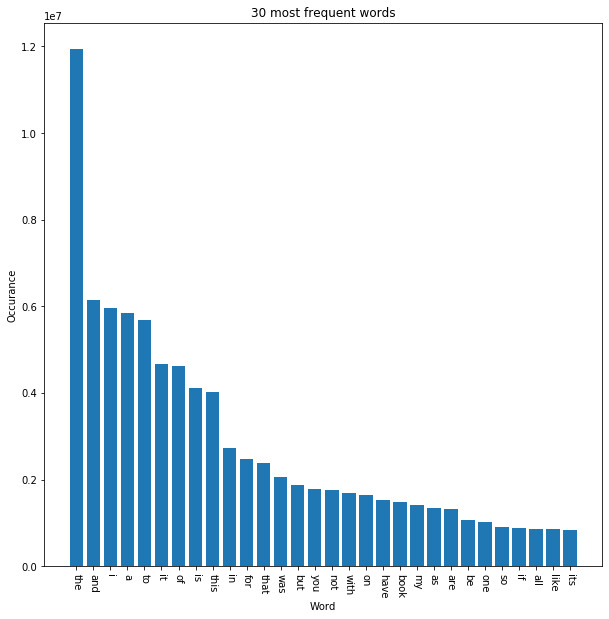

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

word_cnt = rev_tokenizer.word_counts

# Extracts the most frequent words
most_freq_words = 30

sorted_items = list(word_cnt.items())
sorted_items.sort(key=lambda item: item[-1], reverse=True)

most_freq_keys = [k for k, v in sorted_items[:most_freq_words]]
most_freq_values = [v for k, v in sorted_items[:most_freq_words]]

# Draws bar char of most frequent words
plt.figure(figsize=(10, 10))
plt.title(str(most_freq_words) + " most frequent words")
plt.xlabel("Word")
plt.xticks(rotation=-90)
plt.ylabel("Occurance")
plt.bar(most_freq_keys, most_freq_values)

### Step 2: Design & Validate a Model Architecture 


#### Creating data pipeline.

Creating a data pipeline that will produce generator returning *tuple(inputs, targets)* that will be used to train neural network model.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

classes = ["negative", "neutral", "positive"]
# Returns index of a corresponding class in classes list
rating2class = {'1': 0,
                '2': 0,
                '3': 1,
                '4': 2,
                '5': 2}

NUMBER_OF_CLASSES = len(classes)         # Returns number of unique values in rating2class dict 

In [9]:
def skip_rows(gen, num):
    '''Skips rows of csv file read by genertor.

            Parameters:
            gen (generator): csv file reader generator.
            num (int): number of row to be skipped.
    '''
    skipped = 0
    while skipped != num:
        next(gen)
        skipped += 1;

In [10]:
def prepare_text(text):
    '''Returns text without punctuations and all characters are lowercase. Input text remains unmodified.

            Parameters:
            text (str): text based on which new modified string is returned.

            Returns:
            retv (str): returned modified string.
    '''
    retv = text.lower()
    retv = retv.translate(str.maketrans('', '', string.punctuation))
    return retv

In [11]:
def first_pipeline(path, maxlen, batch_size=1, start_idx=0):
    '''Produces generator that will be used to train neural network.

            Parameters:
            path (str): file system path to a csv file with data samples.

            Returns:
            generator: generator that returns tuple(list_of_reviews, list_of_outputs).
    '''
    csv_file = open(path, 'r', errors='ignore')
    reader = csv.reader(csv_file)

    readed_cnt = start_idx
    skip_rows(reader, start_idx)

    while True:
        reviews = []
        ratings = []

        for _ in range(batch_size):
            row = next(reader)
            # Extracts ratings
            rating = row[RATING_IDX]
            rating_class = rating2class[rating]
            ratings.append(rating_class)

            # Extracts and clears reviews
            review = prepare_text(row[REVIEW_IDX])
            reviews.append(review)

            readed_cnt += 1

        # Tokenizes and pads sequences
        reviews = rev_tokenizer.texts_to_sequences(reviews)
        reviews = pad_sequences(reviews, maxlen=maxlen)
        
        # Converts input to binary class matrix
        ratings = to_categorical(ratings, num_classes=NUMBER_OF_CLASSES, dtype='uint8')
            
        yield reviews, ratings, [None]
            
        # Provides infinite data generation
        if readed_cnt + batch_size >= train_samples - 1:
            csv_file.close()
            csv_file = open(path, 'r', errors='ignore')
            reader = csv.reader(csv_file)
            readed_cnt = start_idx
            # Skips first start_idx rows
            skip_rows(reader, start_idx)

#### Creating and training model.

Creating Recurrent Neural Network model and training it.

In [12]:
rev_max_len = 80    # Maximal length of a sequence that can be feed to neural network

model_v1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(rev_max_words, 128, input_length=rev_max_len, name='input_v1'),
    tf.keras.layers.GRU(64, recurrent_dropout=0.2, dropout=0.2),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax', name='output_v1')
])

model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_v1 (Embedding)         (None, 80, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
output_v1 (Dense)            (None, 3)                 195       
Total params: 1,317,443
Trainable params: 1,317,443
Non-trainable params: 0
_________________________________________________________________


In [14]:
def tensorboard_callback(log_dir):
    '''Returns keras.callback object to save tensorboard parameter of trained model.

            Parameters:
            log_dir (str): path to a directory in which we will store information.

            Returns:
            (list of tensorflow.keras.callbacks): list object containg one callback that can be directly use while training.
    '''
    return [tf.keras.callbacks.TensorBoard(
                                    log_dir=log_dir,
                                    histogram_freq=1,
                                    embeddings_freq=1)]

In [15]:
data_gen = first_pipeline(TRAIN_DATA_PATH, maxlen=rev_max_len, batch_size=256)
val_gen = first_pipeline(TRAIN_DATA_PATH, maxlen=rev_max_len, batch_size=256, start_idx=2 * 10^6)

history = model_v1.fit(data_gen, steps_per_epoch=1000,
                       epochs=40, 
                       validation_data=val_gen,
                       validation_steps=500,
                       callbacks=tensorboard_callback('best_sequential_rev_model'),
                       verbose=2)

Train for 1000 steps, validate for 500 steps
Epoch 1/40
1000/1000 - 206s - loss: 0.7900 - acc: 0.6547 - val_loss: 0.6882 - val_acc: 0.7056
Epoch 2/40
1000/1000 - 196s - loss: 0.6870 - acc: 0.7069 - val_loss: 0.6472 - val_acc: 0.7273
Epoch 3/40
1000/1000 - 214s - loss: 0.6588 - acc: 0.7204 - val_loss: 0.6321 - val_acc: 0.7335
Epoch 4/40
1000/1000 - 246s - loss: 0.6450 - acc: 0.7275 - val_loss: 0.6238 - val_acc: 0.7369
Epoch 5/40
1000/1000 - 230s - loss: 0.6332 - acc: 0.7336 - val_loss: 0.6150 - val_acc: 0.7395
Epoch 6/40
1000/1000 - 213s - loss: 0.6153 - acc: 0.7411 - val_loss: 0.6108 - val_acc: 0.7424
Epoch 7/40
1000/1000 - 210s - loss: 0.6117 - acc: 0.7431 - val_loss: 0.5965 - val_acc: 0.7490
Epoch 8/40
1000/1000 - 215s - loss: 0.6047 - acc: 0.7465 - val_loss: 0.5997 - val_acc: 0.7498
Epoch 9/40
1000/1000 - 207s - loss: 0.6000 - acc: 0.7492 - val_loss: 0.5881 - val_acc: 0.7529
Epoch 10/40
1000/1000 - 211s - loss: 0.5980 - acc: 0.7493 - val_loss: 0.5833 - val_acc: 0.7557
Epoch 11/40
10

#### Plots of loss function and accuracy parameters with respect to epoch.

In [20]:
def plot_accuracy(history):
    '''Plots training and validation accuracy obtained in training process.

            Parameters:
            history (tensorflow.python.keras.callbacks.History): history of training.

            Returns:
            matplotlib plot of accuracies with respect to epoch.
    '''
    hist_dict = history.history
    train_acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']

    epochs = np.arange(1, 41)

    plt.plot(epochs, train_acc, 'bo', label='Train accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.grid()
    plt.legend(loc='best')

In [21]:
def plot_loss(history):
    '''Plots training and validation losses obtained in training process.

            Parameters:
            history (tensorflow.python.keras.callbacks.History): history of training.

            Returns:
            matplotlib plot of accuracies with respect to epoch.
    '''
    hist_dict = history.history
    train_loss = hist_dict['loss']
    val_loss = hist_dict['val_loss']
    
    epochs = np.arange(1, 41)
    
    plt.plot(epochs, train_loss, 'bo', label='Train loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.grid()
    plt.legend(loc='best')

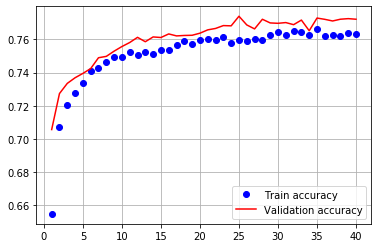

In [22]:
plot_accuracy(history)

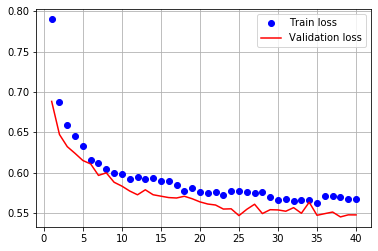

In [23]:
plot_loss(history)

#### Saving best Sequential model of RNN obtain.

In [24]:
model_v1.save('best_sequential_rev_model.h5')

### Step 3: Test Model on New Reviews

In [25]:
test_gen = first_pipeline(TEST_DATA_PATH, maxlen=rev_max_len, batch_size=int(test_samples/1000))

evaluation_v1 = model_v1.evaluate(test_gen, steps=1000)

1000/1000 [==============================] - 62s 62ms/step - loss: 0.5647 - acc: 0.7650


### Step 4: Summary

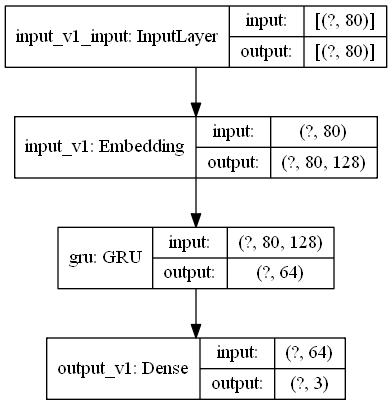

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(model_v1, show_shapes=True, to_file='best_review_sequential_model.png')

## Design sequential architecture that takes review as an input and outputs sentiment.

### Step 1: Preparing data pipeline for new architecture

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

title_max_words = 10000

title_tokenizer = Tokenizer(num_words=title_max_words)
title_gen = flow_from_csv(path=TRAIN_DATA_PATH, col_idx=TITLE_IDX)

title_tokenizer.fit_on_texts(title_gen)

In [28]:
def second_pipeline(path, rev_maxlen, title_maxlen, batch_size=1, start_idx=0):
    '''Produces generator that will be used to train neural network.

            Parameters:
            path (str): file system path to a csv file with data samples.

            Returns:
            generator: generator that returns tuple([list_of_reviews, list_of_titles], list_of_outputs).
    '''
    csv_file = open(path, 'r', errors='ignore')
    reader = csv.reader(csv_file)

    readed_cnt = start_idx
    skip_rows(reader, start_idx)

    while True:
        reviews = []
        titles = []
        ratings = []

        for _ in range(batch_size):
            row = next(reader)
            # Extracts ratings
            rating = row[RATING_IDX]
            rating_class = rating2class[rating]
            ratings.append(rating_class)

            # Extracts and clears reviews
            review = prepare_text(row[REVIEW_IDX])
            reviews.append(review)
            
            # Extracts and clears titles
            title = prepare_text(row[TITLE_IDX])
            titles.append(title)

            readed_cnt += 1

        # Tokenizes and pads sequences of review
        reviews = rev_tokenizer.texts_to_sequences(reviews)
        reviews = pad_sequences(reviews, maxlen=rev_maxlen)
        
        # Tokenizes and pads sequences of titles
        titles = title_tokenizer.texts_to_sequences(titles)
        titles = pad_sequences(titles, maxlen=title_maxlen)
        
        # Converts input to binary class matrix
        ratings = to_categorical(ratings, num_classes=NUMBER_OF_CLASSES, dtype='uint8')
            
        yield [reviews, titles], ratings, [None]
            
        # Provides infinite data generation
        if readed_cnt + batch_size >= train_samples - 1:
            csv_file.close()
            csv_file = open(path, 'r', errors='ignore')
            reader = csv.reader(csv_file)
            readed_cnt = start_idx
            # Skips first start_idx rows
            skip_rows(reader, start_idx)

### Step 2: Design & Validate an RNN muliple inputs architecture

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

rev_max_len = 100
title_max_len = 20

# Constructing new architecture of RNN that take two separate inputs (review and title)
review_input_layer = layers.Input(shape=(rev_max_len,), dtype='int32', name='review_input_v2')
embedded_review = layers.Embedding(rev_max_words, 128, input_length=rev_max_len)(review_input_layer)
review_lstm = layers.LSTM(128, recurrent_dropout=0.4, dropout=0.4)(embedded_review)

title_input_layer = layers.Input(shape=(title_max_len,), dtype='int32', name='title_input_v2')
embedded_title = layers.Embedding(title_max_words, 16, input_length=rev_max_len)(title_input_layer)
title_lstm = layers.LSTM(16, recurrent_dropout=0.2, dropout=0.2)(embedded_title)

# Concatenating layers
concatenated_layer = layers.concatenate([review_lstm, title_lstm], axis=-1)
output_layer = layers.Dense(NUMBER_OF_CLASSES, activation='softmax', name='output_v2')(concatenated_layer)

model_v2 = Model([review_input_layer, title_input_layer], output_layer)

In [30]:
model_v2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [31]:
model_v2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_input_v2 (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
title_input_v2 (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     1280000     review_input_v2[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 16)       160000      title_input_v2[0][0]             
______________________________________________________________________________________________

In [32]:
data_gen = second_pipeline(TRAIN_DATA_PATH, rev_max_len, title_max_len, batch_size=256)
val_gen = second_pipeline(TRAIN_DATA_PATH, rev_max_len, title_max_len, batch_size=256, start_idx=2*10^6)

history = model_v2.fit(data_gen, steps_per_epoch=1000,
                       epochs=40,
                       validation_data=val_gen,
                       validation_steps=500,
                       callbacks=tensorboard_callback('best_multiple_input_model'),
                       verbose=2)

Train for 1000 steps, validate for 500 steps
Epoch 1/40
1000/1000 - 250s - loss: 0.7296 - acc: 0.6870 - val_loss: 0.6229 - val_acc: 0.7382
Epoch 2/40
1000/1000 - 247s - loss: 0.6348 - acc: 0.7345 - val_loss: 0.5874 - val_acc: 0.7560
Epoch 3/40
1000/1000 - 248s - loss: 0.6035 - acc: 0.7481 - val_loss: 0.5709 - val_acc: 0.7617
Epoch 4/40
1000/1000 - 247s - loss: 0.5851 - acc: 0.7565 - val_loss: 0.5603 - val_acc: 0.7673
Epoch 5/40
1000/1000 - 247s - loss: 0.5692 - acc: 0.7639 - val_loss: 0.5434 - val_acc: 0.7753
Epoch 6/40
1000/1000 - 247s - loss: 0.5553 - acc: 0.7711 - val_loss: 0.5521 - val_acc: 0.7707
Epoch 7/40
1000/1000 - 262s - loss: 0.5512 - acc: 0.7717 - val_loss: 0.5359 - val_acc: 0.7786
Epoch 8/40
1000/1000 - 250s - loss: 0.5428 - acc: 0.7757 - val_loss: 0.5363 - val_acc: 0.7797
Epoch 9/40
1000/1000 - 247s - loss: 0.5368 - acc: 0.7789 - val_loss: 0.5237 - val_acc: 0.7835
Epoch 10/40
1000/1000 - 248s - loss: 0.5354 - acc: 0.7785 - val_loss: 0.5202 - val_acc: 0.7857
Epoch 11/40
10

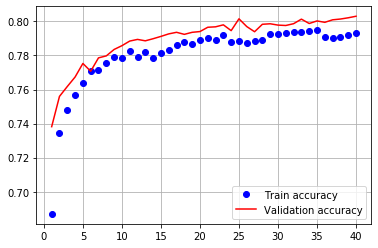

In [33]:
plot_accuracy(history)

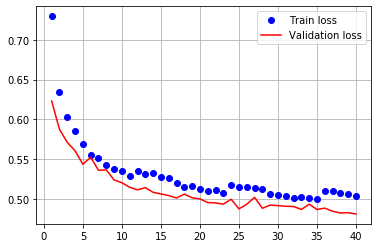

In [34]:
plot_loss(history)

In [35]:
model_v2.save('best_multiple_input_model.h5')

### Step 3: Test obtain model on new data

In [36]:
test_gen = second_pipeline(TEST_DATA_PATH, rev_max_len, title_max_len, batch_size=int(test_samples/1000))

evaluation_v2 = model_v2.evaluate(test_gen, steps=1000)

1000/1000 [==============================] - 86s 86ms/step - loss: 0.4994 - acc: 0.7960


### Step 4: Summary

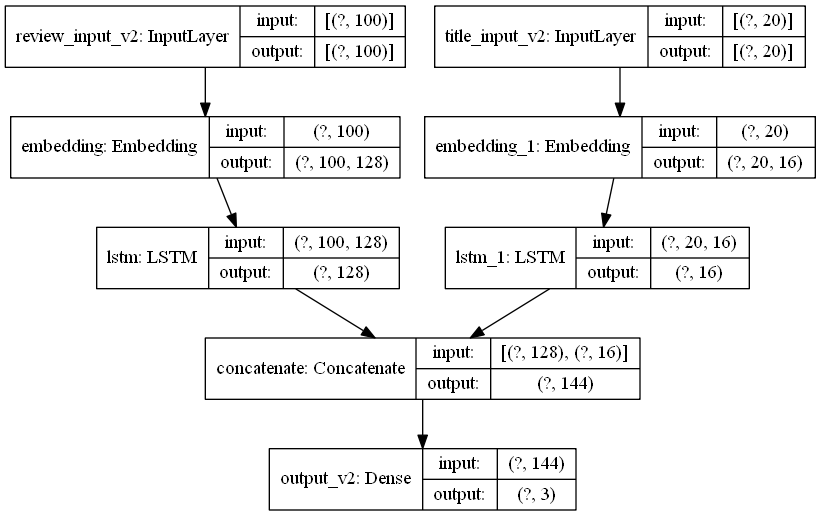

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model_v2, show_shapes=True, to_file='best_multiple_input_model.png')

## Design sequential architecture that takes title as an input and outputs sentiment.

### Step 1: Preparing data pipeline for new architecture

In [38]:
def third_pipeline(path, maxlen, batch_size=1, start_idx=0):
    '''Produces generator that will be used to train neural network.

            Parameters:
            path (str): file system path to a csv file with data samples.

            Returns:
            generator: generator that returns tuple(list_of_titles, list_of_outputs).
    '''
    csv_file = open(path, 'r', errors='ignore')
    reader = csv.reader(csv_file)

    readed_cnt = start_idx
    skip_rows(reader, start_idx)

    while True:
        titles = []
        ratings = []

        for _ in range(batch_size):
            row = next(reader)
            # Extracts ratings
            rating = row[RATING_IDX]
            rating_class = rating2class[rating]
            ratings.append(rating_class)

            # Extracts and clears titles
            title = prepare_text(row[TITLE_IDX])
            titles.append(title)

            readed_cnt += 1

        # Tokenizes and pads sequences
        titles = title_tokenizer.texts_to_sequences(titles)
        titles = pad_sequences(titles, maxlen=maxlen)
        
        # Converts input to binary class matrix
        ratings = to_categorical(ratings, num_classes=NUMBER_OF_CLASSES, dtype='uint8')
            
        yield titles, ratings, [None]
            
        # Provides infinite data generation
        if readed_cnt + batch_size >= train_samples - 1:
            csv_file.close()
            csv_file = open(path, 'r', errors='ignore')
            reader = csv.reader(csv_file)
            readed_cnt = start_idx
            # Skips first start_idx rows
            skip_rows(reader, start_idx)

### Step 2: Design & Validate new architecture

In [39]:
model_v3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(title_max_words, 128, input_length=title_max_len, name='input_v3'),
    tf.keras.layers.LSTM(16, recurrent_dropout=0.2, dropout=0.2),
    tf.keras.layers.Dense(3, activation='softmax', name='output_v3')
])

model_v3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [40]:
model_v3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_v3 (Embedding)         (None, 20, 128)           1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                9280      
_________________________________________________________________
output_v3 (Dense)            (None, 3)                 51        
Total params: 1,289,331
Trainable params: 1,289,331
Non-trainable params: 0
_________________________________________________________________


In [42]:
data_gen = third_pipeline(TRAIN_DATA_PATH, title_max_len, batch_size=256)
val_gen = third_pipeline(TRAIN_DATA_PATH, title_max_len, batch_size=256, start_idx=2*10^6)

history = model_v3.fit(data_gen, steps_per_epoch=1000,
                       epochs=40,
                       validation_data=val_gen,
                       validation_steps=500,
                       callbacks=tensorboard_callback('best_sequential_title_model'),
                       verbose=2)

Train for 1000 steps, validate for 500 steps
Epoch 1/40
1000/1000 - 63s - loss: 0.8107 - acc: 0.6422 - val_loss: 0.7460 - val_acc: 0.6756
Epoch 2/40
1000/1000 - 56s - loss: 0.7494 - acc: 0.6719 - val_loss: 0.7218 - val_acc: 0.6867
Epoch 3/40
1000/1000 - 56s - loss: 0.7323 - acc: 0.6805 - val_loss: 0.7173 - val_acc: 0.6875
Epoch 4/40
1000/1000 - 56s - loss: 0.7235 - acc: 0.6848 - val_loss: 0.7149 - val_acc: 0.6887
Epoch 5/40
1000/1000 - 55s - loss: 0.7144 - acc: 0.6902 - val_loss: 0.7074 - val_acc: 0.6918
Epoch 6/40
1000/1000 - 55s - loss: 0.7066 - acc: 0.6941 - val_loss: 0.7054 - val_acc: 0.6940
Epoch 7/40
1000/1000 - 56s - loss: 0.7053 - acc: 0.6953 - val_loss: 0.7026 - val_acc: 0.6946
Epoch 8/40
1000/1000 - 55s - loss: 0.6976 - acc: 0.6994 - val_loss: 0.6970 - val_acc: 0.6975
Epoch 9/40
1000/1000 - 55s - loss: 0.6918 - acc: 0.7020 - val_loss: 0.6947 - val_acc: 0.7006
Epoch 10/40
1000/1000 - 57s - loss: 0.6922 - acc: 0.7016 - val_loss: 0.6898 - val_acc: 0.7026
Epoch 11/40
1000/1000 - 

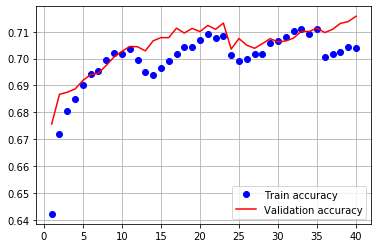

In [43]:
plot_accuracy(history)

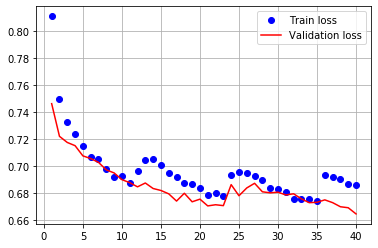

In [44]:
plot_loss(history)

In [49]:
model_v3.save('best_sequetial_title_model.h5')

### Step 3: Test obtain model on new data

In [47]:
test_gen = third_pipeline(TEST_DATA_PATH, title_max_len, batch_size=int(test_samples/1000))

evaluation_v3 = model_v3.evaluate(test_gen, steps=1000)

1000/1000 [==============================] - 23s 23ms/step - loss: 0.6842 - acc: 0.7061


### Step 4: Summary

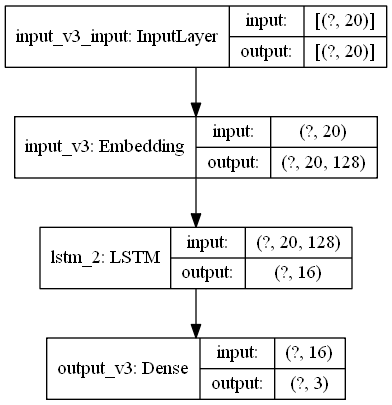

In [48]:
from tensorflow.keras.utils import plot_model

plot_model(model_v3, show_shapes=True, to_file='best_title_sequential_model.png')